<a href="https://colab.research.google.com/github/fantiita/Detector_pH/blob/main/Proyecto_Final_Im%C3%A1genes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title 1) Librerias, Modulos y Parámetros Globales

# Cargar los modulos
import os
import sys
import time
import shutil

# Cargar las librerias
import cv2
import joblib
import sklearn
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Cargar las herramientas de colab
from google.colab import drive, files

# Mostrar versiones
print("==== Versiones de librerías ====")
print(f"Python        : {sys.version.split()[0]}")
print(f"Numpy         : {np.__version__}")
print(f"Pandas        : {pd.__version__}")
print(f"Matplotlib    : {matplotlib.__version__}")
print(f"OpenCV        : {cv2.__version__}")
print(f"Joblib        : {joblib.__version__}")
print(f"Scikit-learn  : {sklearn.__version__}")
print("================================")

==== Versiones de librerías ====
Python        : 3.12.12
Numpy         : 2.0.2
Pandas        : 2.2.2
Matplotlib    : 3.10.0
OpenCV        : 4.12.0
Joblib        : 1.5.2
Scikit-learn  : 1.6.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# @title 2) Montar Drive con la base de datos

# Monta el drive personal
drive.mount('/content/drive')

# Validación de montaje
assert os.path.exists("/content/drive"), "ERROR: Drive no se ha montado correctamente."

# Rutas
ROOT = "/content/drive/MyDrive/Dataset"
CSV  = "/content/drive/MyDrive/Dataset/BaseDatos_pH.csv"

# Validaciones
if not os.path.exists(ROOT):
    raise FileNotFoundError(f"La carpeta ROOT no existe: {ROOT}")

if not os.path.isfile(CSV):
    raise FileNotFoundError(f"No se encontró el archivo CSV: {CSV}")

# Crear carpetas locales
os.makedirs("/content/models", exist_ok=True)
os.makedirs("/content/figs", exist_ok=True)

# Si todo salio bien se vera
print("====================== Drive montado correctamente ======================")
print(f"Ruta ROOT:                {ROOT}")
print(f"Ruta CSV:                 {CSV}")
print("Carpetas locales creadas: /content/models y /content/figs")
print("=========================================================================")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
====================== Drive montado correctamente ======================
Ruta ROOT:                /content/drive/MyDrive/Dataset
Ruta CSV:                 /content/drive/MyDrive/Dataset/BaseDatos_pH.csv
Carpetas locales creadas: /content/models y /content/figs


In [ ]:
# @title 3) Preprocesamiento (color constancia + recorte)

# Cargar la imagen desde su ruta
def CargarImagen(path):
    # Carga imagen BGR con OpenCV
    img = cv2.imread(path, cv2.IMREAD_COLOR_BGR)
    # Si la imagen no pudo cargarse
    if img is None:
        print(f"No pude cargar: {path}")
    return img

# Shades-of-Gray: más robusto que Gray-World ante dominantes fuertes
def ConvertirBGRaGris(img, p=6):
    I = img.astype(np.float32) + 1e-8
    # p-norm por canal
    R = (np.mean(I[:,:,0]**p))**(1/p)
    G = (np.mean(I[:,:,1]**p))**(1/p)
    B = (np.mean(I[:,:,2]**p))**(1/p)
    avg = (R + G + B) / 3.0
    scale = np.array([avg/R, avg/G, avg/B], dtype=np.float32)
    J = (I * scale).clip(0, 255).astype(np.uint8)
    return J

# Recorta por saturación (HSV + morfo), si falla devuelve la original
def RecorteSaturacion(img, s_thresh=40):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    S = hsv[:,:,1]
    mask = (S > s_thresh).astype(np.uint8) * 255
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  kernel)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img
    cnt  = max(contours, key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(cnt)
    crop = img[y:y+h, x:x+w]
    return crop

In [ ]:
# @title 4) Segmentación de pads por picos de gradiente

# Encuentrar k-1 cortes por picos de gradiente (LAB/HSV), si falla usa cortes iguales
def SegmentarGradiente(strip, vertical=True, k=4):
    H, W = strip.shape[:2]
    # Usamos LAB(L) para estructura y HSV(S) para color; combinamos ambos
    L = cv2.cvtColor(strip, cv2.COLOR_BGR2LAB)[:,:,0].astype(np.float32)
    S = cv2.cvtColor(strip, cv2.COLOR_BGR2HSV)[:,:,1].astype(np.float32)
    M = 0.5*L + 0.5*S

    if vertical:  # pads apilados verticalmente → cortes horizontales
        proj = M.mean(axis=1)             # por filas
        grad = np.abs(np.gradient(proj))  # gradiente 1D
        length = H
    else:        # pads en fila → cortes verticales
        proj = M.mean(axis=0)             # por columnas
        grad = np.abs(np.gradient(proj))
        length = W

    # Suavizamos para evitar ruido
    ksize = max(5, length//100)
    kernel = np.ones(ksize, dtype=np.float32)/ksize
    smooth = np.convolve(grad, kernel, mode='same')

    # Buscamos los (k-1) picos más altos alejados de los bordes
    idx = np.arange(length)
    mask_center = (idx > length*0.10) & (idx < length*0.90)
    candidates = [(smooth[i], i) for i in range(length) if mask_center[i]]
    candidates.sort(reverse=True)  # por altura de pico
    cuts = []
    for _, pos in candidates:
        # Evitar cortes muy cercanos entre sí
        if all(abs(pos - c) > length*0.08 for c in cuts):
            cuts.append(pos)
        if len(cuts) == (k-1):
            break

    # Si no se lograron cortes suficientes, usar bandas iguales
    if len(cuts) != (k-1):
        if vertical:
            band = H // k
            cuts = [band, 2*band, 3*band]
        else:
            band = W // k
            cuts = [band, 2*band, 3*band]

    cuts = sorted(cuts)
    return cuts

# Divide en 4 regiones por gradiente y normaliza a 64x64
def Segmentar4Regiones(img_strip):
    H, W = img_strip.shape[:2]
    vertical = (H >= W * 1.2)
    cuts = SegmentarGradiente(img_strip, vertical=vertical, k=4)
    pads = []
    if vertical:
        ranges = [0] + cuts + [H]
        for i in range(4):
            y0, y1 = int(ranges[i]), int(ranges[i+1])
            pads.append(img_strip[y0:y1, :])
    else:
        ranges = [0] + cuts + [W]
        for i in range(4):
            x0, x1 = int(ranges[i]), int(ranges[i+1])
            pads.append(img_strip[:, x0:x1])

    pads_std = [cv2.resize(p, (64,64), interpolation=cv2.INTER_AREA) for p in pads]
    return pads_std

In [ ]:
# @title 5) Características cromáticas (LAB, HSV, cromaticidad) + extracción

# 14 características por pad (media+desv. en LAB/HSV + cromaticidad r,g)
def CaracteristicasRegion(img_pad):
    lab = cv2.cvtColor(img_pad, cv2.COLOR_BGR2LAB)
    L,A,B = cv2.split(lab)
    hsv = cv2.cvtColor(img_pad, cv2.COLOR_BGR2HSV)
    H,S,V = cv2.split(hsv)
    rgb = cv2.cvtColor(img_pad, cv2.COLOR_BGR2RGB).astype(np.float32)+1e-8
    R,G,Bc = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    denom = (R+G+Bc)
    r = (R/denom).mean(); g = (G/denom).mean()
    return np.array([
        L.mean(), L.std(), A.mean(), A.std(), B.mean(), B.std(),
        H.mean(), H.std(), S.mean(), S.std(), V.mean(), V.std(), r, g], dtype=np.float32)

# Pipeline: constancia de color, recorte por saturación, segmentar en 4 regiones y extraer características
def ExtraerCaracteristicas(img_bgr):
    img = ConvertirBGRaGris(img_bgr, p=6)
    crop = RecorteSaturacion(img, s_thresh=40)
    pads = Segmentar4Regiones(crop)
    Fpads = np.vstack([CaracteristicasRegion(p) for p in pads])
    agg_mean = Fpads.mean(axis=0)
    agg_std  = Fpads.std(axis=0)
    return np.concatenate([agg_mean, agg_std]).astype(np.float32)

In [ ]:
# @title 6) Aumento de datos mínimos (rotaciones)

# Genera copias rotadas para robustez. Usamos 90° y 180°
def RotarImagenes(img, angles=[90, 180]):
    augmented = []
    h, w = img.shape[:2]
    center = (w//2, h//2)
    for angle in angles:
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
        augmented.append(rotated)
    return augmented

In [ ]:
# @title 7) Construir datasets A (sin aumento) y B (con aumento)

labels = pd.read_csv(CSV)

# A: sin aumentación
XA, yA = [], []
print("Cargando Dataset A (sin aumentación)...")
for _, row in labels.iterrows():
    # Convertir el nombre del archivo para que coincida con la extensión del archivo real (.JPG a .jpg)
    filename_corrected = str(row["filename"]).replace(".jpg", ".JPG")
    path = os.path.join(ROOT, filename_corrected)
    ph   = float(row["pH"])
    img  = CargarImagen(path)
    if img is None: continue
    XA.append(ExtraerCaracteristicas(img)); yA.append(ph)
XA = np.array(XA, dtype=np.float32); yA = np.array(yA, dtype=np.float32)
print(f"A → {len(XA)} muestras, {XA.shape[1] if XA.shape[0] > 0 else 0} características")

# B: con aumentación
XB, yB = [], []
print("Cargando Dataset B (con aumentación: 90° y 180°)...")
for _, row in labels.iterrows():
    # Convertir el nombre del archivo para que coincida con la extensión del archivo real (.JPG a .jpg)
    filename_corrected = str(row["filename"]).replace(".jpg", ".JPG")
    path = os.path.join(ROOT, filename_corrected)
    ph   = float(row["pH"])
    img  = CargarImagen(path)
    if img is None: continue
    # Originales
    XB.append(ExtraerCaracteristicas(img)); yB.append(ph)
    # Rotadas
    for aug in RotarImagenes(img, angles=[90, 180]):
        XB.append(ExtraerCaracteristicas(aug)); yB.append(ph)
XB = np.array(XB, dtype=np.float32); yB = np.array(yB, dtype=np.float32)
print(f"B → {len(XB)} muestras, {XB.shape[1] if XB.shape[0] > 0 else 0} características")

Cargando Dataset A (sin aumentación)...
A → 91 muestras, 28 características
Cargando Dataset B (con aumentación: 90° y 180°)...
B → 273 muestras, 28 características


In [ ]:
# @title 8) Entrenar y evaluar (GridSearchCV)

# Importamos todas las herramientas necesarias
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

# Semilla de aleatoriedad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def EntrenarEvaluar(X, y, label="A"):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.30, random_state=RANDOM_STATE)
    models = {
        "knn": (
            KNeighborsRegressor(),
            {"knn__n_neighbors":[3, 5, 7],
             "knn__weights":["uniform", "distance"]}
        ),
        "svr": (
            SVR(),
            {"svr__C":[1, 10, 100],
             "svr__gamma":["scale", 0.01],
             "svr__epsilon":[0.0, 0.01]}
        ),
        "rf": (
            RandomForestRegressor(random_state=RANDOM_STATE),
            {"rf__n_estimators":[300, 600],
             "rf__max_depth":[None, 20]}
        )
    }

    best_name, best_est = None, None
    best_score = np.inf

    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    t0 = time.time()

    for name, (est, grid) in models.items():
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            (name, est)
        ])
        gs = GridSearchCV(
            pipe, grid,
            cv=cv, scoring="neg_root_mean_squared_error",
            n_jobs=-1
        )
        gs.fit(Xtr, ytr)

        rmse_cv = -gs.best_score_
        print(f"[{label}:{name}] RMSE CV={rmse_cv:.3f} | Best={gs.best_params_}")

        # Buscar el RMSE más bajo
        if rmse_cv < best_score:
            best_score = rmse_cv
            best_name  = name
            best_est   = gs.best_estimator_

    t1 = time.time()

    # Evaluación final
    pred = best_est.predict(Xte)
    mae  = mean_absolute_error(yte, pred)
    rmse = np.sqrt(mean_squared_error(yte, pred))
    r2   = r2_score(yte, pred)

    print(f"\n[{label}] Mejor modelo: {best_name} | MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f} | tiempo={t1-t0:.1f}s\n")

    return {
        "label":label, "best":best_est,
        "X_test":Xte,"y_test":yte,"pred":pred,
        "mae":mae,"rmse":rmse,"r2":r2
    }

# Ejecutar evaluaciones
resA = EntrenarEvaluar(XA, yA, label="A (sin aumentación)")
resB = EntrenarEvaluar(XB, yB, label="B (con aumentación)")

# Selección del mejor
best_res = resB if resB["rmse"] <= resA["rmse"] else resA

# Guardar modelo
joblib.dump(best_res["best"], "/content/models/best_model.joblib")
print(f"Guardado /content/models/best_model.joblib (de {best_res['label']})")

[A (sin aumentación):knn] RMSE CV=0.692 | Best={'knn__n_neighbors': 3, 'knn__weights': 'distance'}
[A (sin aumentación):svr] RMSE CV=0.681 | Best={'svr__C': 100, 'svr__epsilon': 0.01, 'svr__gamma': 'scale'}
[A (sin aumentación):rf] RMSE CV=0.990 | Best={'rf__max_depth': None, 'rf__n_estimators': 600}

[A (sin aumentación)] Mejor modelo: svr | MAE=0.205 | RMSE=0.277 | R²=0.983 | tiempo=16.3s

[B (con aumentación):knn] RMSE CV=0.196 | Best={'knn__n_neighbors': 3, 'knn__weights': 'distance'}
[B (con aumentación):svr] RMSE CV=0.232 | Best={'svr__C': 100, 'svr__epsilon': 0.01, 'svr__gamma': 0.01}
[B (con aumentación):rf] RMSE CV=0.352 | Best={'rf__max_depth': None, 'rf__n_estimators': 600}

[B (con aumentación)] Mejor modelo: knn | MAE=0.078 | RMSE=0.368 | R²=0.967 | tiempo=26.7s

Guardado /content/models/best_model.joblib (de A (sin aumentación))


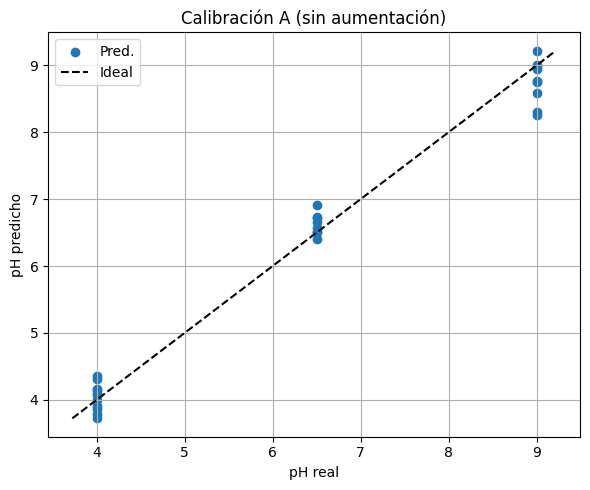

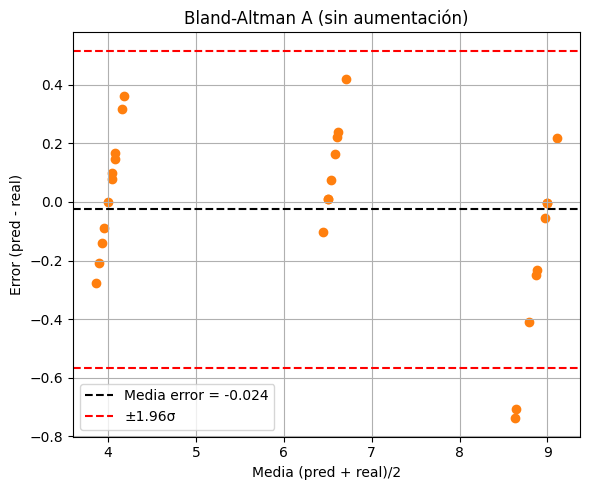

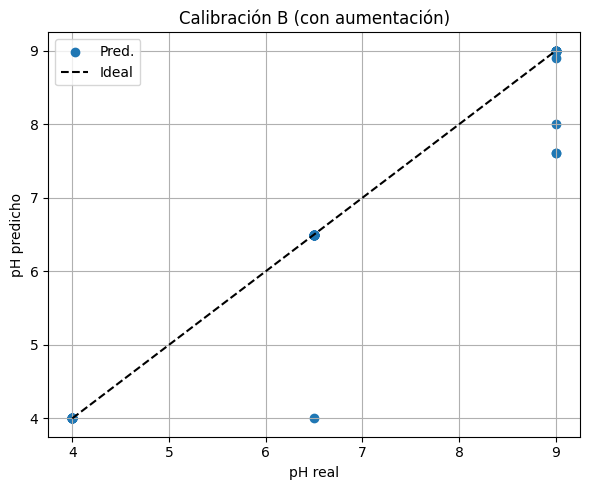

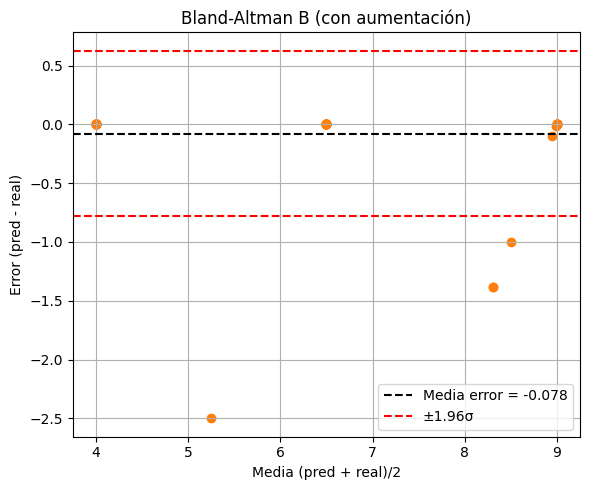

In [ ]:
# @title 9) Visualizacion de Resultados
def MaximoMinimo(a, b):
    return float(min(a, b)), float(max(a, b))

def MostrarCalibracion(y_test, pred, title, path=None):
    plt.figure(figsize=(6,5))
    plt.scatter(y_test, pred, c='tab:blue', label='Pred.')
    a, b = MaximoMinimo(float(y_test.min()), float(pred.min()))
    c, d = MaximoMinimo(float(y_test.max()), float(pred.max()))
    lo, hi = min(a,c), max(b,d)
    plt.plot([lo, hi], [lo, hi], 'k--', label='Ideal')
    plt.xlabel("pH real"); plt.ylabel("pH predicho")
    plt.title(title); plt.grid(True); plt.legend(); plt.tight_layout()
    if path: plt.savefig(path, dpi=150)
    plt.show()

def MostrarBlandAltman(y_test, pred, title, path=None):
    err = pred - y_test
    mean_vals = (pred + y_test)/2
    plt.figure(figsize=(6,5))
    plt.scatter(mean_vals, err, c='tab:orange')
    m = err.mean(); s = err.std()
    plt.axhline(m, color='k', linestyle='--', label=f"Media error = {m:.3f}")
    plt.axhline(m + 1.96*s, color='r', linestyle='--', label='±1.96σ')
    plt.axhline(m - 1.96*s, color='r', linestyle='--')
    plt.xlabel("Media (pred + real)/2"); plt.ylabel("Error (pred - real)")
    plt.title(title); plt.grid(True); plt.legend(); plt.tight_layout()
    if path: plt.savefig(path, dpi=150)
    plt.show()

# A
MostrarCalibracion(resA["y_test"], resA["pred"], "Calibración A (sin aumentación)", "/content/figs/calibracion_A.png")
MostrarBlandAltman(resA["y_test"], resA["pred"], "Bland-Altman A (sin aumentación)", "/content/figs/bland_altman_A.png")

# B
MostrarCalibracion(resB["y_test"], resB["pred"], "Calibración B (con aumentación)", "/content/figs/calibracion_B.png")
MostrarBlandAltman(resB["y_test"], resB["pred"], "Bland-Altman B (con aumentación)", "/content/figs/bland_altman_B.png")

In [ ]:
# @title 10) Inferencia y veredicto

# Tolerancia para veredicto BIEN/MAL
TOL = 0.20

def PredecirpH(imagen):
    model = joblib.load("/content/models/best_model.joblib")
    if isinstance(imagen, str):
        img = CargarImagen(imagen)
    else:
        img = imagen
    feats = ExtraerCaracteristicas(img).reshape(1, -1)
    return float(model.predict(feats)[0])

def Veredicto(real_ph, pred_ph, tol=TOL):
    diff = abs(real_ph - pred_ph)
    return ("BIEN", diff) if diff <= tol else ("MAL", diff)

# Probar en vivo, selecciona una foto y predice pH
print("Sube una foto para probar en vivo…")
uploaded = files.upload()
for fname in uploaded.keys():
    img_path = fname
    ph_pred = PredecirpH(img_path)
    print("====== Predicion de pH ======")
    print(f'Para la Imagen "{fname}"')
    print(f'El pH predicho es: {ph_pred:.2f}')
    print("=============================")

Sube una foto para probar en vivo…


Saving ph9_01.JPG to ph9_01.JPG
====== Predicion de pH ======
Para la Imagen "ph9_01.JPG"
El pH predicho es: 9.01


In [ ]:
# @title 11) Exportar modelo y figuras a Drive
drive_out = "/content/drive/MyDrive/FPDI_pH_entrega"
os.makedirs(drive_out, exist_ok=True)

# Exportar Modelo y figuras
for src in ["/content/models/best_model.joblib",
            "/content/figs/calibracion_A.png",
            "/content/figs/bland_altman_A.png",
            "/content/figs/calibracion_B.png",
            "/content/figs/bland_altman_B.png"]:
    if os.path.exists(src):
        shutil.copy(src, drive_out)

# Generar archivo de versiones para portabilidad
with open(os.path.join(drive_out, "versions.txt"), "w") as f:
    f.write(f"Python        : {sys.version.split()[0]}")
    f.write(f"Numpy         : {np.__version__}")
    f.write(f"Pandas        : {pd.__version__}")
    f.write(f"Matplotlib    : {matplotlib.__version__}")
    f.write(f"OpenCV        : {cv2.__version__}")
    f.write(f"Joblib        : {joblib.__version__}")
    f.write(f"Scikit-learn  : {sklearn.__version__}")

print(f"Exportado a {drive_out}")

Exportado a /content/drive/MyDrive/FPDI_pH_entrega
